# Partial Path Distribution
How does the probability of partial paths(across different layers), $p(L1, L_2, L_3, L_4)$ look like? In this notebook we will try to visualize a more simplified form with only two distributions, $\sum_{i=1}^3 L_i$ and $L_4$. This allows us to plot a 2D heatmap of the probability distribution rather some slices of some 4D plot.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tfo_sensitivity.data import load_raw
import seaborn as sns

# Plot Setup
# plt.style.use('seaborn')
plt.rcParams["figure.dpi"] = 700  # Paper-ready plots
# Load Sim Data
maternal_wall_thickness, uterus_thickness, wave_int = 12, 5, 2
raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)
sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
sim_data['SDD'] = sim_data['X'] - 100
all_sdd = sim_data['SDD'].unique()

all_sdd = sim_data['SDD'].unique()
all_sdd.sort()
current_sdd = all_sdd[1]    

sim_data = sim_data[sim_data['SDD'] == current_sdd]
sim_data["sum_L"] = sim_data["L1 ppath"] + sim_data["L2 ppath"] + sim_data["L3 ppath"]
sim_data.describe()

,X,Y,Z,L1 ppath,L2 ppath,L3 ppath,L4 ppath,SDD,sum_L
count,13961925.0,13961925.0,13961925.0,1.396192e+07,1.396192e+07,1.396192e+07,1.396192e+07,13961925.0,1.396192e+07
mean,114.0,100.0,67.0,1.435536e+02,2.627353e+01,3.835061e+00,4.543643e+01,14.0,1.736622e+02
std,0.0,0.0,0.0,1.195579e+02,7.126948e+01,1.389641e+01,2.505117e+02,0.0,1.849750e+02
min,114.0,100.0,67.0,9.406544e-03,0.000000e+00,0.000000e+00,0.000000e+00,14.0,9.406544e-03
25%,114.0,100.0,67.0,6.173393e+01,0.000000e+00,0.000000e+00,0.000000e+00,14.0,6.176814e+01
50%,114.0,100.0,67.0,1.090057e+02,0.000000e+00,0.000000e+00,0.000000e+00,14.0,1.116337e+02
75%,114.0,100.0,67.0,1.869064e+02,8.258613e+00,0.000000e+00,0.000000e+00,14.0,2.139508e+02
max,114.0,100.0,67.0,2.231930e+03,2.304381e+03,4.477719e+02,1.487017e+04,14.0,4.290134e+03


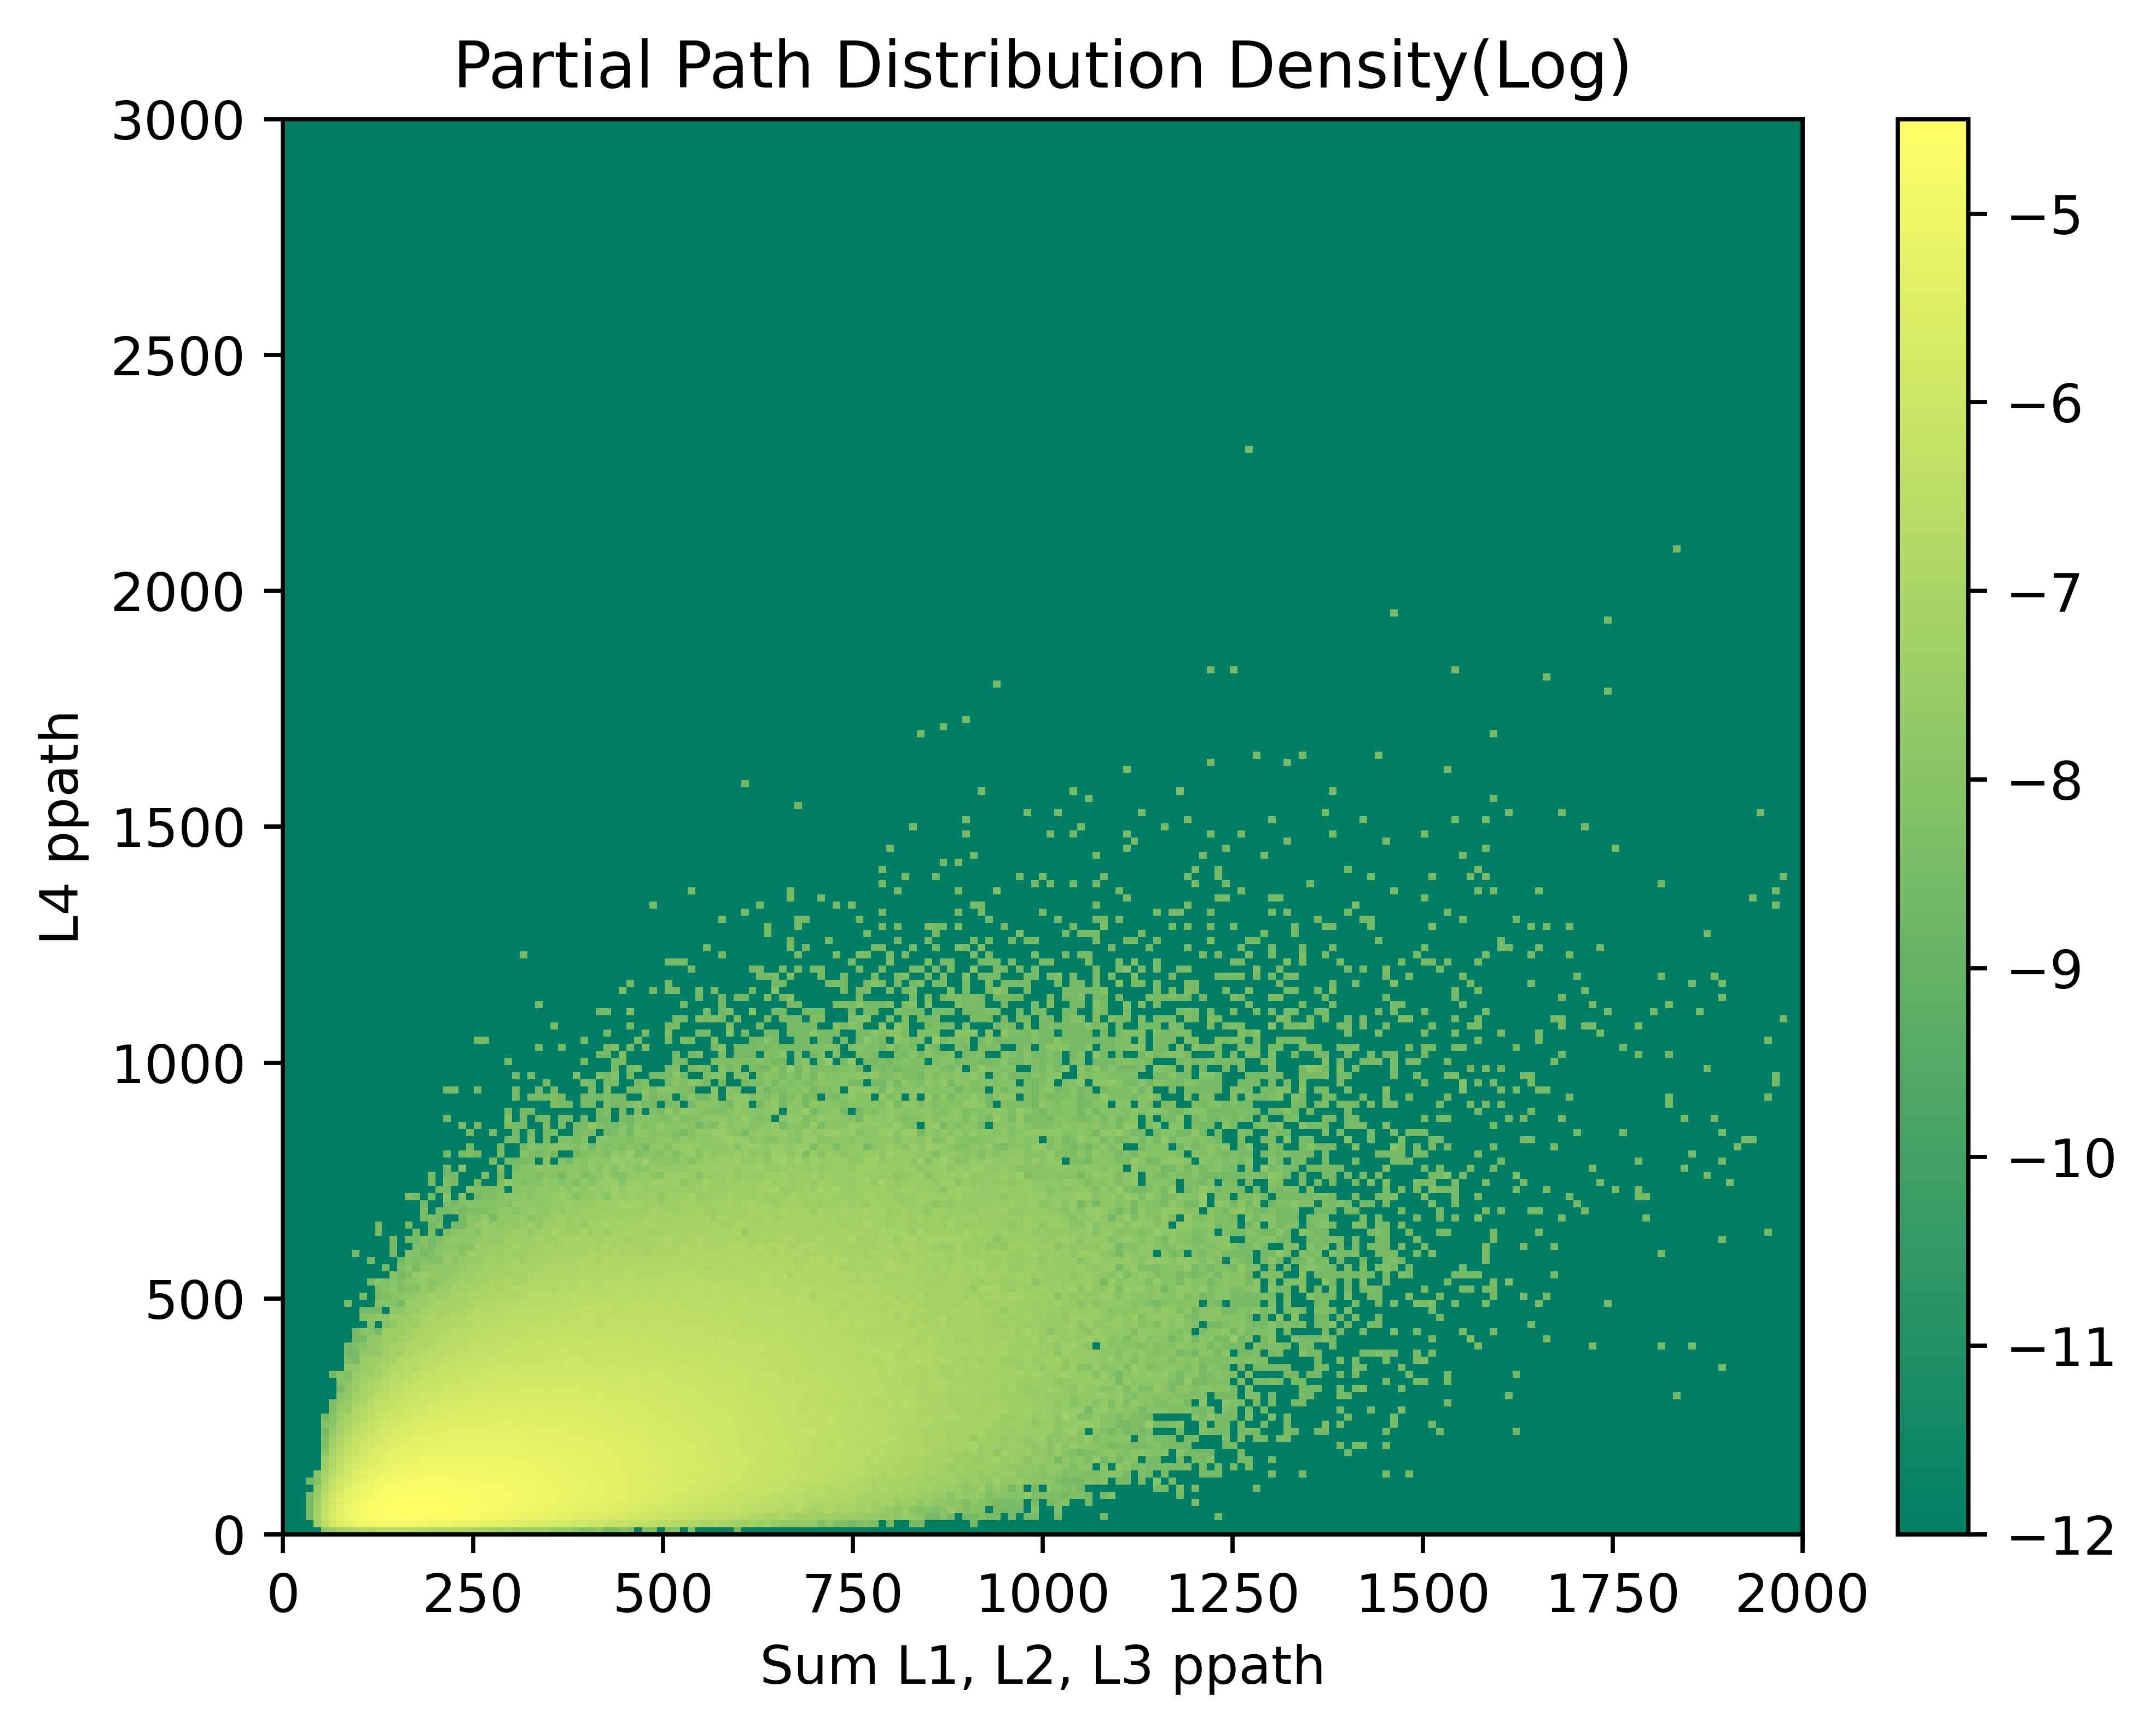

In [2]:
# Create a 2D histogram of the sum_L4 and L4 ppath columns
sim_data = sim_data[sim_data["L4 ppath"] > 0.001]


bin_edges_x = np.linspace(0, 2000, 200)
bin_edges_y = np.linspace(0, 3000, 200)
hist_2d, x_edges, y_edges = np.histogram2d(sim_data["L1 ppath"], sim_data["L2 ppath"], bins=[bin_edges_x, bin_edges_y],
                                           density=True)
# hist_2d, x_edges, y_edges = np.histogram2d(sim_data["sum_L"], sim_data["L4 ppath"], bins=400)

# Plot the 2D histogram
fig, ax = plt.subplots()
EPSILON = 1e-12
hist_2d[hist_2d == 0.0] = EPSILON
plt.imshow(np.log10(hist_2d.T), interpolation='nearest', origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap='summer')

# plt.imshow(hist_2d.T, interpolation='nearest', origin='lower',
#            extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap='summer')
plt.colorbar()
plt.title("Partial Path Distribution Density(Log)")
plt.xlabel('Sum L1, L2, L3 ppath')
plt.ylabel("L4 ppath")
plt.show()
